# Load data

In [84]:
import pandas as pd

# Load the spreadsheet into a Pandas data frame
df_pt = pd.read_excel("data/Bus_patronage.xlsx")

# View some of the data to check what it looks like - head displays some rows from the top of the table
df_pt.head()

,Route,Direction,Stop Sequence,Stop Minute (Sched),Distance from Prev Stop,Seconds from Prev Stop,Passengers Onboard
0,1,1,1,08:02:00,0,0,13
1,1,1,2,08:03:00,502,62,11
2,1,1,3,08:03:00,268,25,17
3,1,1,4,08:04:00,149,16,12
4,1,1,5,08:04:00,268,19,15


In [85]:
# show number of not null rows for each field
df_pt.count()

Route                      13503
Direction                  13503
Stop Sequence              13503
Stop Minute (Sched)        13503
Distance from Prev Stop    13503
Seconds from Prev Stop     13503
Passengers Onboard         13503
dtype: int64

# Filtering

In [87]:
# Select into a new data frame
df_pt_filtered = df_pt.loc[(df_pt["Route"] == 33) & (df_pt["Direction"] == 1)]

# tail displays some rows from the end of the table
df_pt_filtered.tail()

,Route,Direction,Stop Sequence,Stop Minute (Sched),Distance from Prev Stop,Seconds from Prev Stop,Passengers Onboard
9426,33,1,22,17:59:00,137,14,9
9427,33,1,23,18:00:00,214,50,19
9428,33,1,24,18:01:00,211,37,14
9429,33,1,25,18:02:00,296,51,21
9430,33,1,26,18:03:00,224,25,17


# Simple calculations

In [88]:
# Simple transformations
df_pt["Patrons*dist (m)"] = df_pt["Passengers Onboard"] * df_pt["Distance from Prev Stop"]

df_pt.head()

,Route,Direction,Stop Sequence,Stop Minute (Sched),Distance from Prev Stop,Seconds from Prev Stop,Passengers Onboard,Patrons*dist (m)
0,1,1,1,08:02:00,0,0,13,0
1,1,1,2,08:03:00,502,62,11,5522
2,1,1,3,08:03:00,268,25,17,4556
3,1,1,4,08:04:00,149,16,12,1788
4,1,1,5,08:04:00,268,19,15,4020


# Advanced calculations/logic

In [ ]:
def get_peak_hour_approx(time):
    """Return values for 8AM-9:15AM as morning peak, 5PM-6:15PM as evening peak"""
    # time was automatically parsed into a datetime.time object
    hour = time.hour
    minute = time.minute
    if hour == 8 or (hour == 9 and minute <= 15):
        return "AM"
    if hour == 17 or (hour == 18 and minute <= 15):
        return "PM"
    # anything not matching the above will default to None


# Apply the function to the field
df_pt["Peak period"] = df_pt["Stop Minute (Sched)"].apply(get_peak_hour_approx)

# filter out the "NaN" results (i.e. remove rows not in a peak period)
df_pt_peak = df_pt.loc[df_pt["Peak period"].notna()]

df_pt_peak.tail()

,Route,Direction,Stop Sequence,Stop Minute (Sched),Distance from Prev Stop,Seconds from Prev Stop,Passengers Onboard,Patrons*dist (m),Peak period
13492,84,2,21,09:12:00,558,53,75,41850,AM
13493,84,2,22,09:12:00,204,25,36,7344,AM
13494,84,2,23,09:13:00,180,42,39,7020,AM
13495,84,2,24,09:14:00,349,36,18,6282,AM
13496,84,2,25,09:14:00,242,82,35,8470,AM


# Aggregation

In [ ]:
# Group and aggregate (as_index=False keeps the output "flat", with a single header)
df_pt_grouped = df_pt_peak.groupby(
    ["Route", "Direction", "Peak period"], as_index=False
).agg({"Distance from Prev Stop": "sum", "Patrons*dist (m)": "sum"})

df_pt_grouped["Weighted patronage"] = (
    df_pt_grouped["Patrons*dist (m)"] / df_pt_grouped["Distance from Prev Stop"]
)

# Show more rows with head
df_pt_grouped.head(n=20)

Distance from Prev Stop  Patrons*dist (m)  \
Route Direction Peak period                                              
1     1         AM                             16051            383275   
                PM                             15862            372500   
2     1         AM                             17498            592078   
                PM                             74852           1749082   
      2         AM                             42712           1216711   
                PM                             46992           1235467   
3     1         PM                             14690            461063   
      2         AM                             26706            836877   
                PM                             18126            399935   
4     1         AM                             14002            531923   
                PM                             15982            456457   
      2         AM                             15222            312371   
                PM                             19206            464083   
7     1         AM                             32989            782056   
                PM                             14606            336257   
      2         AM                             14592            465398   
                PM                             14113            314836   
13    1         AM                             12224            313353   
                PM                             24448            529859   
      2         AM                             36168            863521   

                             Weighted patronage  
Route Direction Peak period                      
1     1         AM                    23.878575  
                PM                    23.483798  
2     1         AM                    33.836896  
                PM                    23.367205  
      2         AM                    28.486397  
                PM                    26.291007  
3     1         PM                    31.386181  
      2         AM                    31.336666  
                PM                    22.064162  
4     1         AM                    37.989073  
                PM                    28.560693  
      2         AM                    20.521022  
                PM                    24.163439  
7     1         AM                    23.706569  
                PM                    23.021840  
      2         AM                    31.894052  
                PM                    22.308226  
13    1         AM                    25.634244  
                PM                    21.672898  
      2         AM                    23.875276

# Plotting

<Axes: xlabel='Route', ylabel='Weighted patronage'>

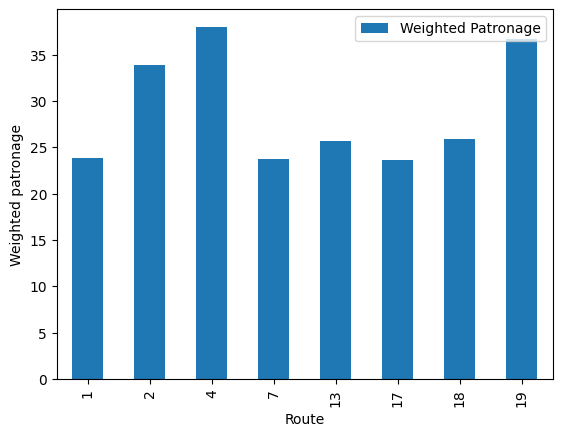

In [ ]:
# minimise data so we don't overload the plot
df_pt_grouped_am = df_pt_grouped.loc[(df_pt_grouped["Peak period"] == "AM") & (df_pt_grouped["Direction"] == 1) & (df_pt_grouped["Route"] < 20)]

# set Route column as the "index"
df_pt_grouped_am.set_index("Route", inplace=True)

# bar plot the weighted patronage for each route
df_pt_grouped_am[["Weighted Patronage"]].plot(kind="bar", ylabel="Weighted patronage", xlabel="Route")

# Export

In [99]:
df_pt_grouped.to_excel("temp.xlsx")